In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import sys

plt.style.use('seaborn')
%matplotlib inline

up_df = pd.read_csv(r'Snapshot CSVs/Up_Snapshot.csv')
rim_df = pd.read_csv(r'Snapshot CSVs/Rim_Snapshot.csv')
fall_df = pd.read_csv(r'Snapshot CSVs/Fall_Snapshot.csv')

def dropAllDuplicates(df):
    duplicates = df.drop(['EVENT_NUM', 'SHOOTER_ID', 'SHOT_DISTANCE', 'SHOT_TIME',
                          'OFFENSIVE_REB', 'EVENT_TIME'], axis=1).duplicated(keep=False)
    return df[~duplicates]

def flipCourt(df):
    xlocs = [col for col in df.columns if ('XLOC' in col) and ('PLAYER' in col)]
    ylocs = [col for col in df.columns if ('YLOC' in col) and ('PLAYER' in col)]
    xvels = [col for col in df.columns if 'XVEL' in col]
    yvels = [col for col in df.columns if 'YVEL' in col]
    
    for i in range(0, len(xlocs)):
        df[xlocs[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                94 - df[xlocs[i]],
                                df[xlocs[i]])
        df[ylocs[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                50 - df[ylocs[i]],
                                df[ylocs[i]])
        df[xvels[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                -1 * df[xvels[i]],
                                df[xvels[i]])
        df[yvels[i]] = np.where(rim_df['BALL_XLOC'] > 47,
                                -1 * df[yvels[i]],
                                df[yvels[i]])
    df['BALL_DISTRIM'] = np.where(rim_df['BALL_XLOC'] > 47,
                                 df['BALL_DIST_RIM2'],
                                 df['BALL_DIST_RIM1'])
    df['BALL_YLOC'] = np.where(rim_df['BALL_XLOC'] > 47,
                                50 - df['BALL_YLOC'],
                                df['BALL_YLOC'])
    df['BALL_XLOC'] = np.where(rim_df['BALL_XLOC'] > 47,
                                94 - df['BALL_XLOC'],
                                df['BALL_XLOC'])
    
    return df

def distToRim(df):
    for i in range(1, 11):
        col = 'PLAYER{}_{}'
        xloc = df[col.format(i, 'XLOC')]
        yloc = df[col.format(i, 'YLOC')]
        df[col.format(i, 'DISTRIM')] = ((xloc-5.25)**2 + (yloc-25)**2)**.5
    return df

def distToBall(df):
    for i in range(1, 11):
        col = 'PLAYER{}_{}'
        xloc = df[col.format(i, 'XLOC')]
        yloc = df[col.format(i, 'YLOC')]
        bx = df['BALL_XLOC']
        by = df['BALL_YLOC']
        df[col.format(i, 'DISTBALL')] = ((xloc-bx)**2 + (yloc-by)**2)**.5
    return df

up_df = dropAllDuplicates(up_df)
rim_df = dropAllDuplicates(rim_df)
fall_df = dropAllDuplicates(fall_df)

up_df = flipCourt(up_df)
fall_df = flipCourt(fall_df)
rim_df = flipCourt(rim_df)

up_df = distToRim(up_df)
fall_df = distToRim(fall_df)
rim_df = distToRim(rim_df)

up_df = distToBall(up_df)
fall_df = distToBall(fall_df)
rim_df = distToBall(rim_df)

In [2]:
# Remove non-shots. These are plays that descend to 11 feet farther than 5 feet away
goodrows = ((rim_df['BALL_DIST_RIM1'] < 5) | (rim_df['BALL_DIST_RIM2'] < 5))

up_df = up_df[goodrows]
rim_df = rim_df[goodrows]
fall_df = fall_df[goodrows]

# Shots outside of 30 feet and rebounds over 20
badrows = ((up_df['BALL_DISTRIM'] > 30) | (fall_df['BALL_DISTRIM'] > 25))

up_df = up_df[~badrows]
rim_df = rim_df[~badrows]
fall_df = fall_df[~badrows]

In [3]:
teamlist = list(up_df['PLAYER1_TEAMID'].unique())

up_df = up_df[~up_df['REBOUNDER_ID'].isin(teamlist)]
rim_df = rim_df[~rim_df['REBOUNDER_ID'].isin(teamlist)]
fall_df = fall_df[~fall_df['REBOUNDER_ID'].isin(teamlist)]

In [4]:
xloc = 'PLAYER{}_{}'
yloc = 'PLAYER{}_{}'
for i in range(1,11):
    xshift = up_df[xloc.format(i,'XLOC')] - 5.25
    yshift = up_df[yloc.format(i,'YLOC')] - 25
    theta = np.arctan2(yshift, xshift)
    
    newx = xshift*np.cos(theta) + yshift*np.sin(theta)
    newy = -xshift*np.sin(theta) + yshift*np.cos(theta)
    
    up_df[xloc.format(i,'BOXEDOUT')] = False
    
    for j in range(1,11):
        if i != j:
            pxshift = up_df[xloc.format(j,'XLOC')] - 5.25
            pyshift = up_df[yloc.format(j,'YLOC')] - 25
            
            px = pxshift*np.cos(theta) + pyshift*np.sin(theta)
            py = -pxshift*np.sin(theta) + pyshift*np.cos(theta)
            
            up_df[xloc.format(i,'BOXEDOUT')] = (up_df[xloc.format(i,'BOXEDOUT')] |
                                                ((0 < newx - px) &
                                                (6 > newx - px) &
                                                (newx > newx - px) &
                                                (np.fabs(py) < np.fabs(px/2)) &
                                                (np.fabs(py) < 2)) &
                                                (np.fabs((newx-px)) > np.fabs(py)))

In [5]:
xloc = 'PLAYER{}_{}'
yloc = 'PLAYER{}_{}'
bx = fall_df['BALL_XLOC']
by = fall_df['BALL_YLOC']

for i in range(1,11):
    xshift = fall_df[xloc.format(i,'XLOC')] - bx
    yshift = fall_df[yloc.format(i,'YLOC')] - by
    theta = np.arctan2(yshift, xshift)
    
    newx = xshift*np.cos(theta) + yshift*np.sin(theta)
    newy = -xshift*np.sin(theta) + yshift*np.cos(theta)
    
    velx = fall_df[xloc.format(i, 'XVEL')]
    vely = fall_df[xloc.format(i, 'YVEL')]
    
    fall_df[xloc.format(i, 'VELRIM')] = -velx*np.cos(theta) - vely*np.sin(theta)
    
    fall_df[xloc.format(i,'BOXEDOUT')] = False
    
    for j in range(1,11):
        if i != j:
            pxshift = fall_df[xloc.format(j,'XLOC')] - bx
            pyshift = fall_df[yloc.format(j,'YLOC')] - by
            
            px = pxshift*np.cos(theta) + pyshift*np.sin(theta)
            py = -pxshift*np.sin(theta) + pyshift*np.cos(theta)
            
            fall_df[xloc.format(i,'BOXEDOUT')] = (fall_df[xloc.format(i,'BOXEDOUT')] |
                                                ((0 < newx - px) &
                                                (6 > newx - px) &
                                                (newx > newx - px) &
                                                (np.fabs(py) < np.fabs(px/2)) &
                                                (np.fabs(py) < 2)) &
                                                (np.fabs((newx-px)) > np.fabs(py)))

In [6]:
# Sums of number of boxed out players for each team
up_df['OFF_BOXEDOUT'] = up_df[['PLAYER1_BOXEDOUT', 'PLAYER2_BOXEDOUT',
                               'PLAYER3_BOXEDOUT', 'PLAYER4_BOXEDOUT',
                               'PLAYER5_BOXEDOUT']].sum(axis=1)
up_df['DEF_BOXEDOUT'] = up_df[['PLAYER6_BOXEDOUT', 'PLAYER7_BOXEDOUT',
                               'PLAYER8_BOXEDOUT', 'PLAYER9_BOXEDOUT',
                               'PLAYER10_BOXEDOUT']].sum(axis=1)

fall_df['OFF_BOXEDOUT'] = fall_df[['PLAYER1_BOXEDOUT', 'PLAYER2_BOXEDOUT',
                               'PLAYER3_BOXEDOUT', 'PLAYER4_BOXEDOUT',
                               'PLAYER5_BOXEDOUT']].sum(axis=1)
fall_df['DEF_BOXEDOUT'] = fall_df[['PLAYER6_BOXEDOUT', 'PLAYER7_BOXEDOUT',
                               'PLAYER8_BOXEDOUT', 'PLAYER9_BOXEDOUT',
                               'PLAYER10_BOXEDOUT']].sum(axis=1)

Rebounder: PLAYER3
PLAYER1_BOXEDOUT      True
PLAYER2_BOXEDOUT      True
PLAYER3_BOXEDOUT     False
PLAYER4_BOXEDOUT     False
PLAYER5_BOXEDOUT      True
PLAYER6_BOXEDOUT     False
PLAYER7_BOXEDOUT     False
PLAYER8_BOXEDOUT      True
PLAYER9_BOXEDOUT     False
PLAYER10_BOXEDOUT    False
OFF_BOXEDOUT             3
DEF_BOXEDOUT             1
Name: 115, dtype: object


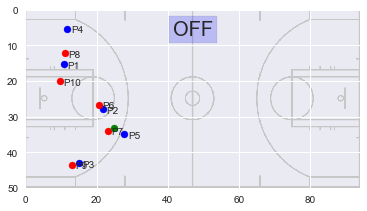

In [7]:
def plotPlay(df, i, suf):
    court = plt.imread("fullcourt.png")
    plt.imshow(court, zorder = 0, extent=[0,94,50,0])
    col = 'PLAYER{}_{}LOC'
    row = df.iloc[i]
    
    for j in range(1,11):
        x = col.format(j, 'X')
        y = col.format(j, 'Y')
        if j <= 5:
            c = 'blue'
        else:
            c = 'red'
        plt.scatter(row[x], row[y], c = c)
        plt.text(row[x]+1, row[y]+1, 'P'+str(j))

    plt.scatter(row['BALL_XLOC'], row['BALL_YLOC'], c = 'green')
#     plt.scatter(row['BALL_XLOC_FALL'], row['BALL_YLOC_FALL'], c = 'green')
    
#     plt.text(row['PLAYER1_XLOC'+suf], row['PLAYER1_YLOC'+suf], 'P1')
    
    if row['OFFENSIVE_REB'] == 1:
        txt = 'OFF'
        col = 'blue'
    else:
        txt = 'DEF'
        col = 'red'
    plt.text(47, 7, txt, fontsize=20, horizontalalignment='center',
             bbox=dict(facecolor=col, alpha=0.2))
    
n = 100

id_cols = [col for col in up_df.columns if '_ID' in col]
b = (up_df.iloc[n][id_cols] == up_df.iloc[n]['REBOUNDER_ID'])
print('Rebounder: {}'.format(b[b==True].index[0][:-3]))

box_cols = [col for col in up_df.columns if 'BOXEDOUT' in col]
print(up_df.iloc[n][box_cols])

plotPlay(up_df, n, '_FALL')

In [8]:
# dist_cols = [col for col in up_df.columns if ('DISTRIM' in col) and ('PLAYER' in col)]
dist_cols = [col for col in fall_df.columns if ('DISTBALL' in col) and ('PLAYER' in col)]
box_cols = [col for col in fall_df.columns if ('BOXEDOUT' in col) and ('PLAYER' in col)]
vel_cols = [col for col in fall_df.columns if ('VELRIM' in col) and ('PLAYER' in col)]

In [9]:
id_cols = [col for col in fall_df.columns if ('_ID' in col) and ('PLAYER' in col)]
rebid = np.repeat(fall_df['REBOUNDER_ID'].values.reshape(len(fall_df), 1),
                  len(id_cols), axis = 1)
fall_df['REBOUNDER_NUM'] = fall_df[id_cols].where(fall_df[id_cols] == rebid, 0).idxmax(axis=1)
fall_df['REBOUNDER_NUM'] = fall_df['REBOUNDER_NUM'].str[:-3] + '_DISTBALL'
fall_df['REBOUNDER_BOXCOL'] = fall_df['REBOUNDER_NUM'].str[:-9] + '_BOXEDOUT'
fall_df['REBOUNDER_DISTBALL'] = fall_df.lookup(fall_df['REBOUNDER_NUM'].index,
                                               fall_df['REBOUNDER_NUM'].values)
fall_df['REBOUNDER_BOXEDOUT'] = fall_df.lookup(fall_df['REBOUNDER_BOXCOL'].index,
                                               fall_df['REBOUNDER_BOXCOL'].values)

In [10]:
vals = fall_df['REBOUNDER_DISTBALL'].values
newvals = np.repeat(vals.reshape(len(vals),1), len(dist_cols), axis = 1)
fall_df['REBOUNDER_POS'] = np.where(newvals > fall_df[dist_cols], True, False).sum(axis=1)

In [11]:
data = fall_df[dist_cols+box_cols+vel_cols].copy()

In [12]:
all_vals = np.empty([0,len(data.columns)])
for i, row in data.iterrows():
    col_order = list(row[dist_cols].sort_values().index)
    col_order = [re.findall('\d+', col)[0] for col in col_order]
    off_order = [x for x in col_order if int(x) <= 5]
    def_order = [x for x in col_order if int(x) > 5]
    player_cols = 'PLAYER{0}_DISTBALL PLAYER{0}_BOXEDOUT PLAYER{0}_VELRIM '
    row_order = ''
    # Put offense in first 5 columns, defense in last 5
    for p in off_order:
        row_order = row_order + player_cols.format(p)
    for p in def_order:
        row_order = row_order + player_cols.format(p)
    all_vals = np.append(all_vals, row[row_order.split()].
                         values.reshape(1,len(data.columns)), axis=0)
    
# Get columns for final data frame. Just players 1-10 where 1 is the closest to hoop
data_cols = ''
for i in range(1, 11):
    data_cols = data_cols + player_cols.format(i)

data = pd.DataFrame(all_vals, columns = data_cols.split())


In [13]:
# data['BALL_DISTRIM_UP'] = up_df['BALL_DISTRIM'].values
# data['BALL_DISTRIM_FALL'] = fall_df['BALL_DISTRIM'].values
# data['REBOUNDER'] = up_df['REBOUNDER_POS'].values
data['OFF_BOXEDOUT'] = fall_df['OFF_BOXEDOUT'].values
data['DEF_BOXEDOUT'] = fall_df['DEF_BOXEDOUT'].values
data['REBOUNDER'] = fall_df['OFFENSIVE_REB'].values
data.to_csv('Rebound_Features.csv', index=False)

In [14]:
# from imblearn.over_sampling import RandomOverSampler

# X = outdf.drop('Off_Reb', axis = 1)
# y = outdf['Off_Reb']

# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_sample(X, y)

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     test_size=0.3, random_state=0)
# model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#                                     max_depth=1, random_state=0)
# model2.fit(X_train, y_train)
# predicted = model2.predict(X_test)
# print(model2.score(X_test, y_test))
# print(metrics.confusion_matrix(y_test, predicted))

In [15]:
# from sklearn import linear_model

# def rebLength(X):
#     tempX = X['BALL_DISTRIM_UP'].values.reshape(-1,1)
#     tempy = X['BALL_DISTRIM_FALL']
#     model = linear_model.LinearRegression()
#     model.fit(tempX, tempy)
#     y_pred = model.predict(tempX)
#     return y_pred

In [16]:
# import time
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.cross_validation import train_test_split
# from sklearn import metrics
# from sklearn.cross_validation import cross_val_score
# from sklearn.model_selection import GridSearchCV

# X = outdf.drop('Player_Num', axis = 1)
# y = outdf['Player_Num']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# t0 = time.time()
# # No data split
# model = KNN(n_neighbors=3)
# model.fit(X_train, y_train)
# predicted = model.predict(X_test)
# # print(metrics.precision_score(y_test, predicted))
# # print(metrics.recall_score(y_test, predicted))
# print(metrics.confusion_matrix(y_test, predicted))
# t1 = time.time()
# print (t1 - t0)

In [17]:
# parameters = {'n_neighbors': range(1,100)}
# knn = KNN()
# knnmodel = GridSearchCV(knn, parameters)
# knnmodel.fit(X_train, y_train)

In [18]:
# pd.DataFrame(list(zip(X.columns, [x[0] for x in np.transpose(model.coef_)])))

In [19]:
# Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# model2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
#                                     max_depth=1, random_state=0)
# model2.fit(X_train, y_train)
# predicted = model2.predict(X_test)
# print(metrics.confusion_matrix(y_test, predicted))

In [20]:
# Cross-validation
# t0 = time.time()
# scores = cross_val_score(KNN(n_neighbors=30), X, y, scoring='accuracy', cv=10)
# print(scores.mean())
# t1 = time.time()
# print(t1 - t0)

In [21]:
# Cross-validation
# t0 = time.time()
# scores = cross_val_score(GradientBoostingClassifier(n_estimators=100,
#                                                     learning_rate=1.0,
#                                                     max_depth=1,
#                                                     random_state=0),
#                          X_resampled, y_resampled, scoring='accuracy', cv=10)
# print(scores.mean())
# t1 = time.time()
# print(t1 - t0)